In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTENC
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import time
import warnings
warnings.filterwarnings("ignore")

In [29]:
# Load in data, create train, validation split, get categorical variables when suing SMOTENC
train = pd.read_csv('train_clean.csv', index_col=[0])
test = pd.read_csv('test_clean.csv', index_col=[0])
xf_train = train.loc[:,train.columns != 'Attrition_Yes']
yf_train = train.Attrition_Yes
x_train, x_val, y_train, y_val = train_test_split(train.loc[:,train.columns != 'Attrition_Yes'], train.Attrition_Yes, test_size = 0.2)

x_cat = [x_train.columns.get_loc(c) for c in x_train.columns if '_' in c]

In [30]:
# Conduct 5-fold cross validation on max_depth, gamma parameters, store result
max_depths = [1, 2, 3, 5, 8]
gammas = [0, 1, 2, 4, 8]

kfold = KFold(n_splits=5)
k_by_md_train_scores = []
k_by_gamma_val_scores = []
for md in max_depths:
    by_g_train_scores = []
    by_g_val_scores = []
    for g in gammas:
        train_scores = []
        val_scores = []
        for tr_idx, val_idx in kfold.split(xf_train):
            xt_up, yt_up = SMOTENC(categorical_features=x_cat, k_neighbors=15).fit_resample(xf_train.iloc[tr_idx], yf_train.iloc[tr_idx])
            xgb_clf = XGBClassifier(gamma=g, max_depth=md, verbosity=0).fit(xt_up.iloc[tr_idx], yt_up.iloc[tr_idx])
            # print(f1_score(xgb_clf.predict(xf_train.iloc[val_idx]), yf_train.iloc[val_idx]))
            train_scores.append(f1_score(xgb_clf.predict(xf_train.iloc[tr_idx]), yf_train.iloc[tr_idx]))
            val_scores.append(f1_score(xgb_clf.predict(xf_train.iloc[val_idx]), yf_train.iloc[val_idx]))
        by_g_train_scores.append(np.mean(train_scores))
        by_g_val_scores.append(np.mean(val_scores))
    k_by_md_train_scores.append(by_g_train_scores)
    k_by_gamma_val_scores.append(by_g_val_scores)

Text(0.5, 1.0, 'XGBoost Cross Validation Validation Fold F1 Scores')

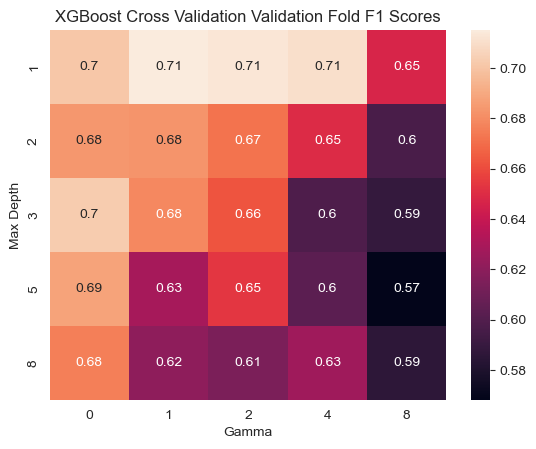

In [31]:
# Visualize validation f1 scores from cross validation
xgb_train_scores = pd.DataFrame(k_by_md_train_scores)
xgb_val_scores = pd.DataFrame(k_by_gamma_val_scores)

xgb_val_scores.columns = gammas
xgb_val_scores.index = max_depths

xgb_train_scores.columns = gammas
xgb_train_scores.index = max_depths

sns.heatmap(xgb_val_scores, annot=True)
plt.ylabel('Max Depth')
plt.xlabel('Gamma')
plt.title('XGBoost Cross Validation Validation Fold F1 Scores')
# plt.savefig('Graphs/XGBCVVal.png', bbox_inches='tight')

Text(0.5, 1.0, 'XGBoost Cross Validation Train Fold F1 Scores')

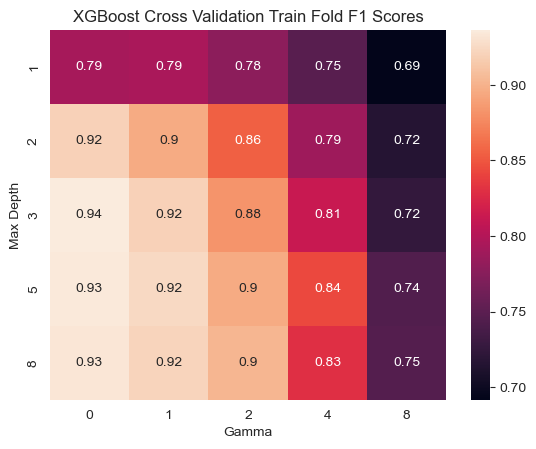

In [32]:
# Visualize train f1 scores from cross validation
sns.heatmap(xgb_train_scores, annot=True)
plt.ylabel('Max Depth')
plt.xlabel('Gamma')
plt.title('XGBoost Cross Validation Train Fold F1 Scores')
# plt.savefig('Graphs/XGBCVTrain.png', bbox_inches='tight')

0.07808208465576172


Text(0.5, 0, 'Feature Importance')

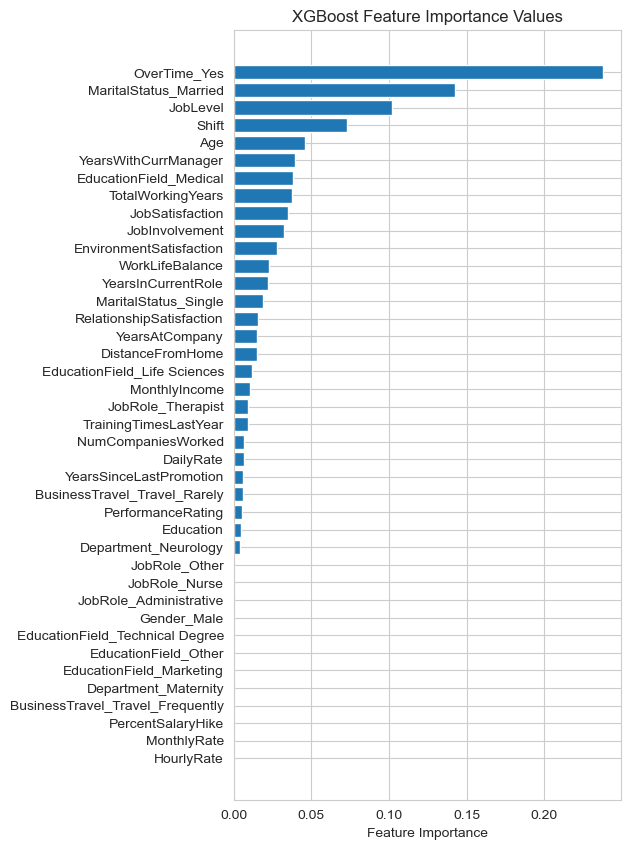

In [33]:
# Make bar chart of feature importance values
xt_up, yt_up = SMOTENC(categorical_features=x_cat, k_neighbors=15).fit_resample(xf_train, yf_train)
cur = time.time()
xgb_clf = XGBClassifier(gamma=1, max_depth=1).fit(xt_up, yt_up)
print(time.time() - cur)
plt.figure(figsize=(5,10))
f_i = list(zip(xt_up.columns, xgb_clf.feature_importances_))
f_i.sort(key=lambda x: x[1], reverse=False)
s_c = [x[0] for x in f_i]
s_f = [x[1] for x in f_i]
plt.barh(s_c, s_f)
plt.title('XGBoost Feature Importance Values')
plt.xlabel('Feature Importance')
# plt.savefig('Graphs/XGBoostFI.png', bbox_inches='tight')

Train f1:  0.9522309711286089
Val f1:  0.6764705882352942


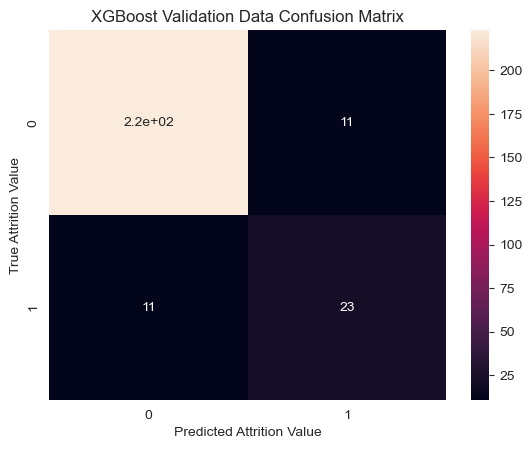

In [34]:
# Generate confusion matrix on validation data
smote = SMOTENC(categorical_features=x_cat, k_neighbors=5)
xsr_train, ysr_train = smote.fit_resample(x_train, y_train)
xgb_sr_model = XGBClassifier(n_estimators= 200, gamma=4, max_depth=1, min_child_weight=20, reg_lambda = 7, subsample=0.3, eta=0.2).fit(xsr_train, ysr_train)
print('Train f1: ', f1_score(xgb_sr_model.predict(xsr_train), ysr_train))
print('Val f1: ', f1_score(xgb_sr_model.predict(x_val), y_val))
sns.heatmap(confusion_matrix(y_pred=xgb_sr_model.predict(x_val), y_true=y_val), annot=True)
plt.title('XGBoost Validation Data Confusion Matrix')
plt.xlabel('Predicted Attrition Value')
plt.ylabel('True Attrition Value')
plt.savefig('Graphs/XGBCM.png', bbox_inches='tight')

In [35]:
# Generate submissions using best model as determined through cross validation
smote = SMOTENC(categorical_features=x_cat, k_neighbors=10)
xf_sr_train, yf_sr_train = smote.fit_resample(xf_train, yf_train)
xgb_predictions_model = XGBClassifier(n_estimators= 200, gamma=4, max_depth=1, min_child_weight=20, reg_lambda = 7, subsample=0.3, eta=0.2).fit(xf_sr_train, yf_sr_train)
submission18 = pd.DataFrame(xgb_predictions_model.predict(test)).rename(columns={0: 'Predicted'})
submission18.index.rename('Id', inplace=True)
submission18.to_csv('submission18.csv')